# Eurostat notebook

## Introduction

"Eurostat is the statistical office of the European Union.", says the official [webpage](https://ec.europa.eu/eurostat/web/main/about-us/who-we-are). Eurostat stores and manages data of European countries on different levels (NUTS 0-3) covering many topics. Its web interface is user-friendly and well maintained, but in various situations you need to access, explore, manipulate, analyze and visualize data through Python. And that's what this notebook is about.

This notebook is a practical guide on the Eurostat Python API and how to read any dataset from Eurostat. You'll learn how to work with DataFrames and GeoDataFrames, how to join the Eurostat dataset into those data structures and how to visualize them.

You'll need a Python environment, for example conda, to use it as a kernel and to install packages into it. This notebook was developed and tested using cloned ArcGIS Pro Python 3.9.18 environment. 6 extra libraries were installed into this environment: [**Eurostat**](https://pypi.org/project/eurostat/), [**GeoPandas**](https://geopandas.org/en/stable/), [**Requests**](https://pypi.org/project/requests/), [**Pandas**](https://pandas.pydata.org/) and [**Matplotlib**](https://matplotlib.org/stable/). You can install them using Visual Studio Code terminal, Python Command Prompt or navigating to your Python environment in cmd and running this command: ```pip install package_name```.

The workflow is divided into the following sections:
- [Choosing Eurostat dataset](#eurostat)
- [Read NUTS2 regions into GeoDataFrame](#geojson)
- [Join the dataset to the NUTS2 GeoDataFrame](#join)
- [Visualizations: plots and maps](#visual)

## Choosing Eurostat dataset <a id="eurostat"></a>

In [1]:
import eurostat

The first step is to read the Eurostat table of contents into a dataframe by [**get_toc_df()**](https://pypi.org/project/eurostat/) function. It retrieves the titles, codes and timestamps of all Eurostat datasets.

In [4]:
toc_df = eurostat.get_toc_df()
toc_df

title  \
0     Gross weight of goods transported to/from main...   
1     Volume of containers transported to/from main ...   
2     Volume of containers transported to/from main ...   
3     Volume of containers transported to/from main ...   
4     Volume of containers transported to/from main ...   
...                                                 ...   
7653  Percentage of letters delivered on-time (USP u...   
7654                                    Postal services   
7655    Number of enterprises providing postal services   
7656  Access points  (USP under direct or indirect d...   
7657  Domestic postal traffic, letter mail and parce...   

                         code     type       last update of data  \
0                MAR_GO_QM_BG  dataset  2024-03-18T23:00:00+0100   
1             MAR_GO_QM_C1999  dataset  2018-07-09T23:00:00+0200   
2             MAR_GO_QM_C2002  dataset  2018-07-09T23:00:00+0200   
3             MAR_GO_QM_C2004  dataset  2018-11-09T23:00:00+0100   
4             MAR_GO_QM_C2006  dataset  2019-06-26T23:00:00+0200   
...                       ...      ...                       ...   
7653  POST_CUBE1_X$POST_QOS_1  dataset      2024-03-14T12:09:14Z   
7654             POST_CUBE1_X  dataset      2024-03-14T12:05:33Z   
7655      POST_CUBE1_X$NUM701  dataset      2024-03-14T12:09:14Z   
7656  POST_CUBE1_X$POST_ACC_1  dataset      2024-03-14T12:09:14Z   
7657  POST_CUBE1_X$POST_DTR_1  dataset      2024-03-14T12:09:14Z   

     last table structure change data start data end  
0       2024-03-18T23:00:00+0100    2001-Q1  2023-Q4  
1       2023-11-22T11:00:00+0100    1997-Q1  1999-Q4  
2       2023-11-22T11:00:00+0100    2000-Q1  2002-Q4  
3       2023-11-22T11:00:00+0100    2003-Q1  2004-Q4  
4       2023-11-22T11:00:00+0100    2005-Q1  2006-Q4  
...                          ...        ...      ...  
7653        2024-03-14T12:09:14Z       None     None  
7654        2024-03-14T12:05:33Z       2012     2022  
7655        2024-03-14T12:09:14Z       None     None  
7656        2024-03-14T12:09:14Z       None     None  
7657        2024-03-14T12:09:14Z       None     None  

[7658 rows x 7 columns]

You can filter the datasets by *keyword*. Function [**subset_toc_df()**](https://pypi.org/project/eurostat/) extracts the datasets where the title contains *keyword*. Let's pick a keyword, for example ```'science'```.

In [5]:
sc_datasets = eurostat.subset_toc_df(toc_df, 'science')
sc_datasets

title             code  \
1846  Human resources in science and technology (HRS...         TGS00038   
4035  Low achieving 15-year-olds in reading, mathema...   EDUC_OUTC_PISA   
4161   Human resources in science and technology (HRST)         TSC00025   
4458  Graduates in tertiary education, in science, m...  EDUC_UOE_GRAD04   
4475  Graduates at doctoral level, in science, math....  EDUC_UOE_GRAD07   
6212  Low achieving 15-year-olds in reading, mathema...        SDG_04_40   

         type       last update of data last table structure change  \
1846  dataset  2024-03-15T23:00:00+0100    2024-03-15T23:00:00+0100   
4035  dataset  2023-12-14T11:00:00+0100    2024-01-03T23:00:00+0100   
4161  dataset  2024-03-14T23:00:00+0100    2024-03-14T23:00:00+0100   
4458  dataset  2024-01-26T11:00:00+0100    2024-01-03T23:00:00+0100   
4475  dataset  2023-12-12T11:00:00+0100    2024-01-03T23:00:00+0100   
6212  dataset  2024-01-03T23:00:00+0100    2024-01-03T23:00:00+0100   

     data start data end  
1846       2011     2022  
4035       2000     2022  
4161       2011     2022  
4458       2012     2021  
4475       2013     2021  
6212       2000     2022

Unfortunately, titles are a bit longer so they are not fully visible. Select only necessary attributes ```'title'```, ```'code'```, ```'data start'``` and ```'data end'``` by [**DataFrame.loc**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html) method. Then set ```'title'``` as the DataFrame's index by [**set_index()**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.set_index.html) function so you can access the values by dataset's title and you can see the whole title.

In [6]:
sc_datasets = sc_datasets.loc[:, ('title', 'code', 'data start', 'data end')]
sc_datasets.set_index('title', inplace=True)
sc_datasets

code  \
title                                                                 
Human resources in science and technology (HRST...         TGS00038   
Low achieving 15-year-olds in reading, mathemat...   EDUC_OUTC_PISA   
Human resources in science and technology (HRST)           TSC00025   
Graduates in tertiary education, in science, ma...  EDUC_UOE_GRAD04   
Graduates at doctoral level, in science, math.,...  EDUC_UOE_GRAD07   
Low achieving 15-year-olds in reading, mathemat...        SDG_04_40   

                                                   data start data end  
title                                                                   
Human resources in science and technology (HRST...       2011     2022  
Low achieving 15-year-olds in reading, mathemat...       2000     2022  
Human resources in science and technology (HRST)         2011     2022  
Graduates in tertiary education, in science, ma...       2012     2021  
Graduates at doctoral level, in science, math.,...       2013     2021  
Low achieving 15-year-olds in reading, mathemat...       2000     2022

Let's choose the [**Human resources in science and technology (HRST) by NUTS 2 regions**](https://ec.europa.eu/eurostat/databrowser/view/tgs00038/default/table?lang=en) as the working dataset for this notebook.

Use [**get_data_df()**](https://pypi.org/project/eurostat/) function to read the dataset, specified by its code, into a dataframe.

In [8]:
code = sc_datasets.loc['Human resources in science and technology (HRST) by NUTS 2 regions', 'code']
data = eurostat.get_data_df(code)
data

freq category    unit geo\TIME_PERIOD  2011  2012  2013  2014  2015  2016  \
0      A     HRST  PC_ACT            AT11  35.8  34.9  37.4  43.5  45.3  45.1   
1      A     HRST  PC_ACT            AT12  37.5  37.9  39.2  46.1  47.3  47.1   
2      A     HRST  PC_ACT            AT13  46.5  47.4  50.5  56.6  56.1  55.9   
3      A     HRST  PC_ACT            AT21  35.9  36.5  37.7  44.2  43.9  45.5   
4      A     HRST  PC_ACT            AT22  35.4  36.8  36.2  41.5  43.1  43.7   
..   ...      ...     ...             ...   ...   ...   ...   ...   ...   ...   
336    A     HRST  PC_ACT            UKM6  45.2  47.6  51.0  48.5  49.0  50.2   
337    A     HRST  PC_ACT            UKM7   NaN   NaN  56.5  56.3  57.5  59.3   
338    A     HRST  PC_ACT            UKM8   NaN   NaN  52.0  53.0  55.7  58.3   
339    A     HRST  PC_ACT            UKM9   NaN   NaN  47.7  49.4  48.9  52.4   
340    A     HRST  PC_ACT            UKN0  42.0  45.0  44.4  45.7  46.1  45.6   

     2017  2018  2019  2020  2021  2022  
0    47.2  46.4  48.6  51.4  49.9  50.5  
1    49.2  49.5  49.1  51.0  52.0  51.2  
2    56.9  55.5  56.6  57.2  57.9  60.1  
3    45.3  47.7  47.0  49.1  50.0  49.1  
4    44.4  45.3  46.0  46.9  46.7  49.0  
..    ...   ...   ...   ...   ...   ...  
336  52.9  49.8  53.0   NaN   NaN   NaN  
337  60.4  59.2  61.4   NaN   NaN   NaN  
338  57.0  56.9  60.4   NaN   NaN   NaN  
339  52.5  52.1  54.5   NaN   NaN   NaN  
340  48.1  48.6  51.0   NaN   NaN   NaN  

[341 rows x 16 columns]

Get the column names by [**get_pars()**](https://pypi.org/project/eurostat/) function and save them in a list ```columns```.

In [9]:
columns = eurostat.get_pars(code)
columns

['freq', 'category', 'unit', 'geo']

Maybe you know what these abbreviations stand for, but it's not 100% clear. Get the full names and meanings of these columns using [**get_dic()**](https://pypi.org/project/eurostat/) function.

In [7]:
columns_meanings = eurostat.get_dic(code)
columns_meanings

[('freq',
  'Time frequency',
  'This code list contains the periodicity that refers to the frequency.'),
 ('category', 'Category', None),
 ('unit', 'Unit of measure', None),
 ('geo',
  'Geopolitical entity (reporting)',
  'This code list defines the reporting geopolitical entities.')]

Now get the column values and their meanings by using the same **get_dic()** function. You have to provide more parameters in order to get that, so let's break it down:
- ```code```: variable ```code``` that specifies the dataset
- ```par```: for which column you want to get the values and their meanings
- ```full```: boolean parameter that determins whether you want values only in this dataset (```False```) or the list of all possible values (```True```) 
- ```frmt```: format in which you want to get it, there are 3 options = dictionary (```'dict'```), dataframe (```'df'```), list (```'list'```)

In [8]:
column_dict = []
for column in columns:
    column_dict.append(eurostat.get_dic(code, par=column, full=False, frmt='dict'))
column_dict

[{'A': 'Annual'},
 {'HRST': 'Persons with tertiary education (ISCED) and/or employed in science and technology'},
 {'PC_ACT': 'Percentage of population in the labour force'},
 {'EA20': 'Euro area – 20 countries (from 2023)',
  'BE10': 'Région de Bruxelles-Capitale/Brussels Hoofdstedelijk Gewest',
  'BE21': 'Prov. Antwerpen',
  'BE22': 'Prov. Limburg (BE)',
  'BE23': 'Prov. Oost-Vlaanderen',
  'BE24': 'Prov. Vlaams-Brabant',
  'BE25': 'Prov. West-Vlaanderen',
  'BE31': 'Prov. Brabant wallon',
  'BE32': 'Prov. Hainaut',
  'BE33': 'Prov. Liège',
  'BE34': 'Prov. Luxembourg (BE)',
  'BE35': 'Prov. Namur',
  'BG31': 'Severozapaden',
  'BG32': 'Severen tsentralen',
  'BG33': 'Severoiztochen',
  'BG34': 'Yugoiztochen',
  'BG41': 'Yugozapaden',
  'BG42': 'Yuzhen tsentralen',
  'CZ01': 'Praha',
  'CZ02': 'Střední Čechy',
  'CZ03': 'Jihozápad',
  'CZ04': 'Severozápad',
  'CZ05': 'Severovýchod',
  'CZ06': 'Jihovýchod',
  'CZ07': 'Střední Morava',
  'CZ08': 'Moravskoslezsko',
  'DK01': 'Hovedstade

Let's do a little exercise: print the codes and names of all NUTS2 in Czech Republic (NUTS2 code start with ```'CZ'```).

In [9]:
for code, full_name in column_dict[3].items():
    if 'CZ' in code:
        print(f"{code}: {full_name}")

CZ01: Praha
CZ02: Střední Čechy
CZ03: Jihozápad
CZ04: Severozápad
CZ05: Severovýchod
CZ06: Jihovýchod
CZ07: Střední Morava
CZ08: Moravskoslezsko


## Read NUTS2 regions into GeoDataFrame <a id="geojson"></a>

Import package [**requests**](https://pypi.org/project/requests/) for sending http requests to download data, built-in module [**os**](https://www.w3schools.com/python/module_os.asp) for managing files and directories and [**geopandas**](https://geopandas.org/en/stable/) to work with spatial data in the GeoDataFrame format.

In [10]:
import requests
import os
import geopandas

Set parameters and variables for downloading NUTS2 regions geojson file from the EU database of geographical information [GISCO](https://ec.europa.eu/eurostat/web/gisco).

In [11]:
# URL of the NUTS2 geojson to download
url = "https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_01M_2021_4326_LEVL_2.geojson"

# NUTS2 regions will be downloaded in 1:1 000 000 scale resolution, valid for the year 2021 and in EPSG:4326 crs (WGS 84)
file_name = "NUTS_RG_01M_2021_4326_LEVL_2.geojson"

# set your own path where you want to save the geojson, it's recommended to save it in the same directory as this notebook is
file_path = os.path.join("D:/ArcGIS_Notebooks_thesis/eurostat/", file_name)

This next cell will download the NUTS2 regions geojson. At first it'll check if it hasn't already been downloaded by [**os.path.exists**](https://www.geeksforgeeks.org/python-os-path-exists-method/) function. If not, then a GET request is sent to the ```url``` where the geojson is stored and if this request is successful (status code *200*), then it's downloaded and saved where you set the ```file_path```.

In [12]:
if os.path.exists(file_path):
    print("NUTS2 geojson file has already been downloaded.")
else:
    # object response contains the result of the GET request to the specified URL
    response = requests.get(url)

    if response.status_code == 200:
        # write the content to a file
        with open(file_path, 'wb') as f:
            f.write(response.content)
        print(f"File '{file_name}' downloaded successfully!")
    else:
        print("Failed to download the file.")

NUTS2 geojson file has already been downloaded.


Read now the downloaded geojson into a GeoDataFrame ```gdf_from_geojson``` using [**read_file()**](https://geopandas.org/en/stable/docs/reference/api/geopandas.read_file.html#geopandas.read_file) function and print its first 5 rows (GeoDataFrame.head()).

In [13]:
gdf_from_geojson = geopandas.read_file(file_path)
gdf_from_geojson.head()

id NUTS_ID  LEVL_CODE CNTR_CODE             NAME_LATN  \
0  DE12    DE12          2        DE             Karlsruhe   
1  CH05    CH05          2        CH            Ostschweiz   
2  CZ02    CZ02          2        CZ         Střední Čechy   
3  CH01    CH01          2        CH      Région lémanique   
4  BE24    BE24          2        BE  Prov. Vlaams-Brabant   

              NUTS_NAME  MOUNT_TYPE  URBN_TYPE  COAST_TYPE   FID  \
0             Karlsruhe         0.0          0           0  DE12   
1            Ostschweiz         0.0          0           0  CH05   
2         Střední Čechy         0.0          0           0  CZ02   
3      Région lémanique         0.0          0           0  CH01   
4  Prov. Vlaams-Brabant         0.0          0           0  BE24   

                                            geometry  
0  MULTIPOLYGON (((9.60382 49.42658, 9.57113 49.4...  
1  MULTIPOLYGON (((8.61383 47.80108, 8.62155 47.7...  
2  MULTIPOLYGON (((15.14677 50.52294, 15.14161 50...  
3  MULTIPOLYGON (((6.78005 46.85264, 6.74231 46.8...  
4  POLYGON ((5.10348 50.70906, 5.09468 50.70367, ...

You can see that there are 3 columns which possibly contain the same values: ```id```, ```NUTS_ID``` and ```FID```. Verify whether they really contain the same values by creating lists from these columns and comparing them. If they are identical, you can carry on with only one of them.

In [14]:
id_list = gdf_from_geojson['id'].tolist()     #https://datatofish.com/convert-pandas-dataframe-to-list/
nuts_id_list = gdf_from_geojson['NUTS_ID'].tolist()
fid_list = gdf_from_geojson['FID'].tolist()

if id_list == nuts_id_list == fid_list:
    print("IDs in all three columns 'id', 'NUTS_ID' and 'FID' are identical")
else:
    print("IDs are not identical")

IDs in all three columns 'id', 'NUTS_ID' and 'FID' are identical


Do the same for columns ```NAME_LATN``` and ```NUTS_NAME```, because they also look like they contain the same values.

In [15]:
name_latn_list = gdf_from_geojson['NAME_LATN'].tolist()
nuts_name_list = gdf_from_geojson['NUTS_NAME'].tolist()

if name_latn_list == nuts_name_list:
    print("names in the columns 'NAME_LATN' and 'NUTS_NAME' are identical")
else:
    print("names in the columns 'NAME_LATN' and 'NUTS_NAME' are not identical")

names in the columns 'NAME_LATN' and 'NUTS_NAME' are not identical


After these columns control you can save the GeoDataFrame only with important columns. You can drop the columns ```id```, ```LEVL_CODE```, ```MOUNT_TYPE```, ```URBN_TYPE```, ```COAST_TYPE``` and ```FID```.

In [16]:
gdf_from_geojson = gdf_from_geojson.loc[:, ('NUTS_ID', 'CNTR_CODE', 'NAME_LATN', 'NUTS_NAME', 'geometry')]
gdf_from_geojson

NUTS_ID CNTR_CODE               NAME_LATN               NUTS_NAME  \
0      DE12        DE               Karlsruhe               Karlsruhe   
1      CH05        CH              Ostschweiz              Ostschweiz   
2      CZ02        CZ           Střední Čechy           Střední Čechy   
3      CH01        CH        Région lémanique        Région lémanique   
4      BE24        BE    Prov. Vlaams-Brabant    Prov. Vlaams-Brabant   
..      ...       ...                     ...                     ...   
329    NO0A        NO              Vestlandet              Vestlandet   
330    TR51        TR                  Ankara                  Ankara   
331    TR52        TR          Konya, Karaman          Konya, Karaman   
332    HR05        HR             Grad Zagreb             Grad Zagreb   
333    NO0B        NO  Jan Mayen and Svalbard  Jan Mayen and Svalbard   

                                              geometry  
0    MULTIPOLYGON (((9.60382 49.42658, 9.57113 49.4...  
1    MULTIPOLYGON (((8.61383 47.80108, 8.62155 47.7...  
2    MULTIPOLYGON (((15.14677 50.52294, 15.14161 50...  
3    MULTIPOLYGON (((6.78005 46.85264, 6.74231 46.8...  
4    POLYGON ((5.10348 50.70906, 5.09468 50.70367, ...  
..                                                 ...  
329  MULTIPOLYGON (((9.06206 62.37261, 9.01855 62.3...  
330  POLYGON ((33.46440 38.63659, 33.45947 38.64448...  
331  POLYGON ((33.46440 38.63659, 33.36248 38.56250...  
332  POLYGON ((16.15481 45.96877, 16.15674 45.96095...  
333  MULTIPOLYGON (((33.09131 80.24908, 33.09929 80...  

[334 rows x 5 columns]

At this point you know what the ```gdf_from_geojson``` contain but you don't know how it looks like on the map. Use [**plot()**](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot) function to plot it.

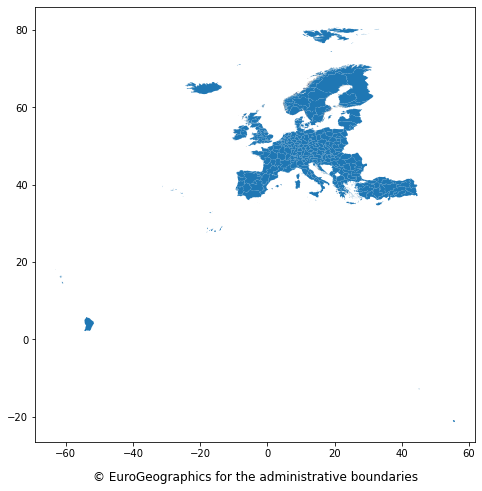

In [17]:
ax = gdf_from_geojson.plot(figsize=(8, 8))
_ = ax.set_xlabel('© EuroGeographics for the administrative boundaries', fontsize = 12, labelpad = 12.0)

As you can see from the plot above, there NUTS2 regions cover also overseas territories that are not necessary for this use case and often doesn't contain any data. You can drop them by slicing the ```gdf_from_geojson``` by coordinates. GeoDataFrame "provides coordinate based [**indexing**](https://geopandas.org/en/stable/docs/user_guide/indexing.html) with the ```cx``` indexer, which slices using a bounding box". 

So now select only those regions which are located between 34° and 70° north latitude and east of 15° west longitude. Save them into a new GeoDataFrame ```nuts2_gdf```, print the number of regions and plot them.

325


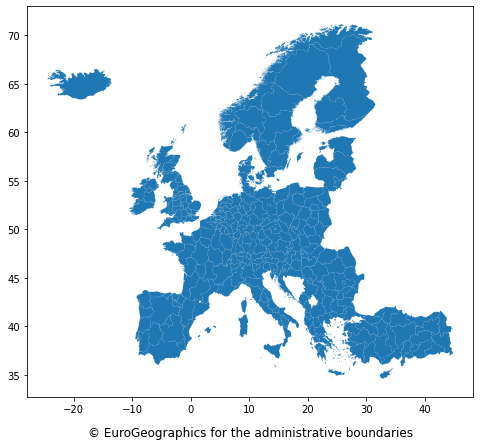

In [18]:
nuts2_gdf = gdf_from_geojson.cx[-15:, 34:70]
print(len(nuts2_gdf))
ax = nuts2_gdf.plot(figsize=(8, 8))
_ = ax.set_xlabel('© EuroGeographics for the administrative boundaries', fontsize = 12, labelpad = 12.0)

The ```nuts2_gdf``` is currently saved in [EPSG:4326](https://epsg.io/4326) coordinate reference system (crs) WGS 84. However, the crs with the best projection for the whole Europe is [EPSG:3035](https://epsg.io/3035) crs ETRS89-extended/LAEA Europe. It distorts the angles but preserves the areas. Project the GeoDataFrame into it using [**to_crs()**](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.to_crs.html) function and plot it to see the difference between EPSG:4326 and EPSG:3035.

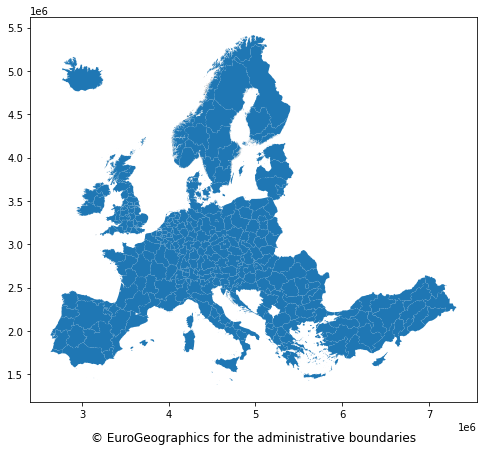

In [19]:
nuts2_gdf = nuts2_gdf.to_crs("EPSG:3035")
ax = nuts2_gdf.plot(figsize=(8, 8))
_ = ax.set_xlabel('© EuroGeographics for the administrative boundaries', fontsize = 12, labelpad = 12.0)

## Join the dataset to the NUTS2 GeoDataFrame <a id="join"></a>

At this point you have 2 separate NUTS2 data structures: 
- ```data``` DataFrame that contains Eurostat dataset **"Human resources in science and technology (HRST) by NUTS 2 regions"** 
- ```nuts2_gdf``` GeoDataFrame that contains NUTS2 regions with their geometry

Join ```data``` to ```nuts2_gdf``` in order to make maps of HRST in European regions. You have to find a common column in both tables (primary and foreign key) before joining them together. It is the ```NUTS_ID``` column in ```nuts2_gdf``` and the ```geo``` column in ```data```. [**Rename**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html) the column ```'geo\TIME_PERIOD'``` to ```'NUTS_ID'``` in ```data```.

In [20]:
data.rename(columns = {'geo\TIME_PERIOD':'NUTS_ID'}, inplace = True)
data.head()

freq category    unit NUTS_ID  2011  2012  2013  2014  2015  2016  2017  \
0    A     HRST  PC_ACT    AT11  35.8  34.9  37.4  43.5  45.3  45.1  47.2   
1    A     HRST  PC_ACT    AT12  37.5  37.9  39.2  46.1  47.3  47.1  49.2   
2    A     HRST  PC_ACT    AT13  46.5  47.4  50.5  56.6  56.1  55.9  56.9   
3    A     HRST  PC_ACT    AT21  35.9  36.5  37.7  44.2  43.9  45.5  45.3   
4    A     HRST  PC_ACT    AT22  35.4  36.8  36.2  41.5  43.1  43.7  44.4   

   2018  2019  2020  2021  2022  
0  46.4  48.6  51.4  49.9  50.5  
1  49.5  49.1  51.0  52.0  51.2  
2  55.5  56.6  57.2  57.9  60.1  
3  47.7  47.0  49.1  50.0  49.1  
4  45.3  46.0  46.9  46.7  49.0

Now you can join ```data``` to ```nuts2_gdf``` using [**merge()**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) function. Save it in a new GeoDataFrame ```nuts2_gdf_hrst```.

In [21]:
nuts2_gdf_hrst = nuts2_gdf.merge(data, on='NUTS_ID')
nuts2_gdf_hrst.head()

NUTS_ID CNTR_CODE             NAME_LATN             NUTS_NAME  \
0    DE12        DE             Karlsruhe             Karlsruhe   
1    CH05        CH            Ostschweiz            Ostschweiz   
2    CZ02        CZ         Střední Čechy         Střední Čechy   
3    CH01        CH      Région lémanique      Région lémanique   
4    BE24        BE  Prov. Vlaams-Brabant  Prov. Vlaams-Brabant   

                                            geometry freq category    unit  \
0  MULTIPOLYGON (((4292253.705 2923819.973, 42898...    A     HRST  PC_ACT   
1  MULTIPOLYGON (((4217105.198 2744025.879, 42176...    A     HRST  PC_ACT   
2  MULTIPOLYGON (((4685657.738 3058491.488, 46853...    A     HRST  PC_ACT   
3  MULTIPOLYGON (((4075295.021 2643018.666, 40722...    A     HRST  PC_ACT   
4  POLYGON ((3975414.370 3077940.643, 3974754.391...    A     HRST  PC_ACT   

   2011  2012  2013  2014  2015  2016  2017  2018  2019  2020  2021  2022  
0  45.7  46.8  47.1  47.3  48.3  48.5  48.7  48.4  50.5  50.7  51.4  52.2  
1  42.0  42.2  44.2  45.3  45.9  47.6  48.3  49.7  51.6  52.0  51.4  50.4  
2  34.4  36.7  36.6  37.3  37.1  36.6  38.0  40.0  39.1  39.2  40.0  39.6  
3  49.5  50.2  50.3  51.0  51.2  52.8  54.7  55.2  55.9  55.7  54.8  54.4  
4  55.2  56.1  54.8  56.6  56.3  58.3  61.9  59.1  60.6  63.1  65.1  62.7

Print the number of rows in this newly merged GeoDataFrame ```nuts2_gdf_hrst```.

In [22]:
print(len(nuts2_gdf_hrst))
print(len(nuts2_gdf))

321
325


Why is there 4 less rows compared to the original GeoDataFrame ```nuts2_gdf``` (321 vs 325)? It's because the eurostat dataset HRST didn't have the data for all NUTS2. Get the ```'NUTS_ID'``` of the 4 NUTS2 regions that are missing in the eurostat dataset and save them in the ```difference``` list.

In [23]:
# get nuts2 ids from both geodataframes and save them in lists
nuts2_gdf_id_list = nuts2_gdf['NUTS_ID'].tolist()
nuts2_gdf_hrst_id_list = nuts2_gdf_hrst['NUTS_ID'].tolist()

# define new list difference
difference = []
# loop through the ids in the nuts2_gdf, where there are more nuts2 regions
for id in nuts2_gdf_id_list:
    # if id is not in the nuts2_gdf_hrst id list, add it to the difference list
    if id not in nuts2_gdf_hrst_id_list:
        difference.append(id)

# print the ids of 4 missing nuts2 regions
difference

['AL01', 'AL02', 'AL03', 'LI00']

Set the ```NUTS_ID``` column as the index for ```nuts2_gdf``` and print the 4 missing NUTS2 regions in a table and on a map.

In [24]:
# set_index() => https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.set_index.html
nuts2_gdf.set_index('NUTS_ID', inplace=True)
nuts2_gdf.loc[difference, :]

CNTR_CODE      NAME_LATN      NUTS_NAME  \
NUTS_ID                                           
AL01           AL           Veri           Veri   
AL02           AL         Qender         Qender   
AL03           AL            Jug            Jug   
LI00           LI  Liechtenstein  Liechtenstein   

                                                  geometry  
NUTS_ID                                                     
AL01     POLYGON ((5129579.218 2204098.703, 5129899.812...  
AL02     POLYGON ((5178239.016 2085653.856, 5180303.196...  
AL03     MULTIPOLYGON (((5211962.703 2061668.486, 52149...  
LI00     POLYGON ((4292201.681 2670971.921, 4292532.342...

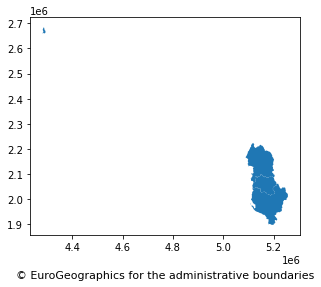

In [25]:
ax = nuts2_gdf.loc[difference, :].plot()
_ = ax.set_xlabel('© EuroGeographics for the administrative boundaries', fontsize = 11, labelpad = 18.0)

In [26]:
# to reset index back to default integers, use the reset_index() function
#nuts2_gdf.reset_index()

## Visualizations: plots and maps <a id="visual"></a>

In this part you will take a closer look at the HRST eurostat dataset by visualizing data in a various ways.

Import [**pandas**](https://pandas.pydata.org/docs/index.html) package for better manipulation with DataFrames.

In [27]:
import pandas

First you are going to create a line plot that demonstrates the development of HRST in NUTS2 regions throughout the years 2011-2022. In order to keep it consistent, remove the regions that contain null values. You can do that by [**dropna**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html) function.

233


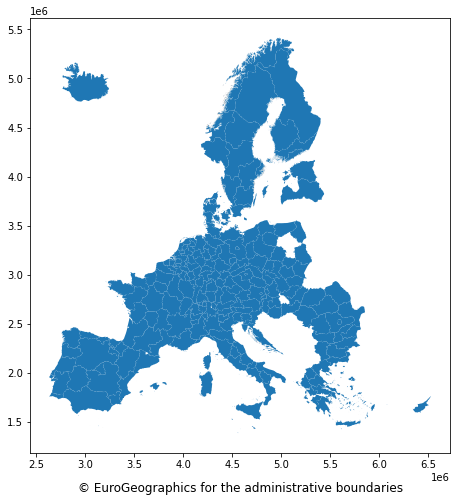

In [28]:
complete_hrst = nuts2_gdf_hrst.dropna()
print(len(complete_hrst))
ax = complete_hrst.plot(figsize=(8,8))
_ = ax.set_xlabel('© EuroGeographics for the administrative boundaries', fontsize = 12, labelpad = 12.0)

### Basic statistics, boxplots, histograms

Find [**minimum**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.min.html), [**maximum**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.max.html), [**median**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.median.html) and [**mean**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mean.html) values for all years and save them in a new DataFrame ```stat_df```. Each function (**min**, **max**, **median**, **mean**) returns values for all columns in the GeoDataFrame, but you need it only for the columns that contain the percentage of people in science and technology sector. Fortunately, these are the only numeric columns of this GeoDataFrame, the rest is of types like string and geometry, therefore you can use filtering parameter ```numeric_only=True``` which will return values only from the numeric columns.

In [29]:
# new DataFrame stat_df is filled with minima at first
stat_df = pandas.DataFrame(complete_hrst.max(numeric_only=True), columns=['max'])

# auxiliary list dfs will contain 3 DataFrames, one for maxima, the second one for means and the third for medians
dfs = []
dfs.append(pandas.DataFrame(complete_hrst.median(numeric_only=True), columns=['median']))
dfs.append(pandas.DataFrame(complete_hrst.mean(numeric_only=True), columns=['mean']))
dfs.append(pandas.DataFrame(complete_hrst.min(numeric_only=True), columns=['min']))

# now the 3 DataFrames are joined to the stat_df in this for loop using merge function
for df in dfs:
    stat_df = stat_df.merge(df, left_index=True, right_index=True)

# print the stat_df
stat_df

max  median       mean   min
2011  66.8    38.6  37.851073  17.4
2012  62.8    39.5  38.687983  17.9
2013  61.7    40.2  39.355794  16.5
2014  62.4    41.4  40.150644  17.0
2015  62.8    42.3  40.857511  15.1
2016  64.2    43.1  41.564378  15.8
2017  66.2    43.9  42.363090  16.3
2018  66.6    44.6  43.043777  16.9
2019  66.7    45.6  43.748069  15.9
2020  70.5    46.6  44.858369  15.6
2021  69.0    46.6  45.476824  19.7
2022  71.2    47.0  45.780687  21.7

For better visualization of the line plot's x axis convert the years (that are index for ```stat_df```) from a string to a datetime type. Use [**pandas.to_datetime()**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html).

In [30]:
stat_df.index = pandas.to_datetime(stat_df.index)

Finally you can create the line plot showing how the maximum, median, mean and minimum percentages of labour force employed/educated in science and technology evolved from 2011 to 2022. Use the [**DataFrame.plot()**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html) function and [matplotlib.axes](https://matplotlib.org/stable/api/axes_api.html) documentation to configure the plot.

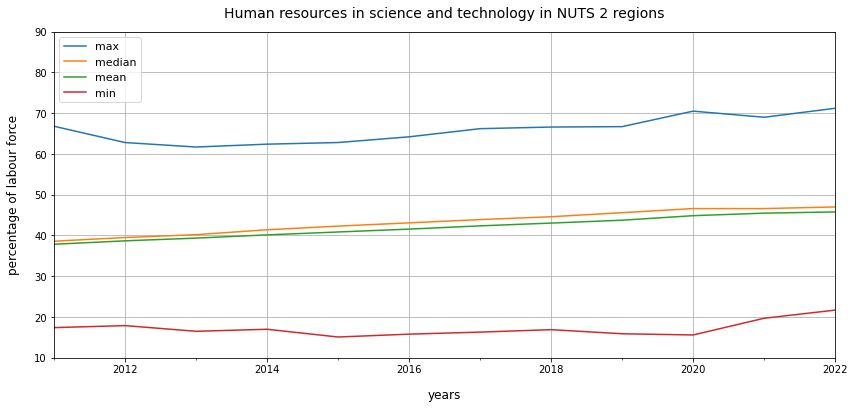

In [31]:
ax = stat_df.plot(figsize=[14,6], use_index=True, grid=True, ylim=[10,90])
ax.legend(loc='upper left', fontsize=11)
ax.set_title('Human resources in science and technology in NUTS 2 regions', fontsize=14, pad=14.0)
ax.set_xlabel('years', fontsize=12, labelpad=14.0)
_ = ax.set_ylabel('percentage of labour force', fontsize=12, labelpad=14.0)

You can see that there is a slow gradual growth in median and mean from below of 40% of labour forces employed/educated in science and technology in 2011 to around 47% and 46%, respectively. Maximum and minimum percentages don't grow that gradually since they are the extreme values and they vary from year to year, but overall these values grown from 2011 to 2022. 

Check the percentages distribution in years 2011 and 2022 by generating histograms ([**DataFrame.hist**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.hist.html)).

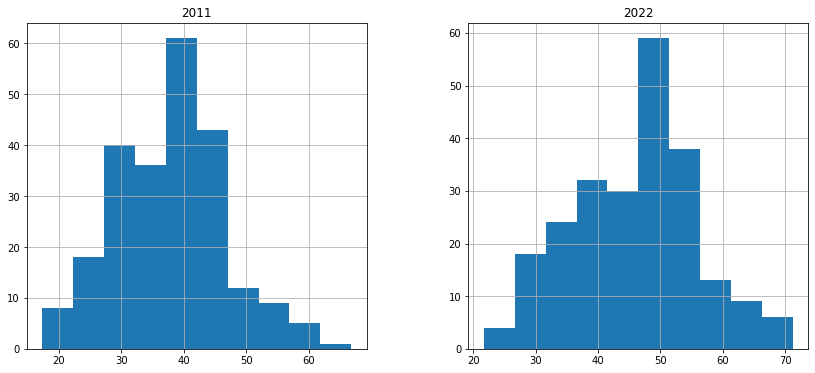

In [32]:
_ = complete_hrst.hist(column=['2011', '2022'], figsize=(14,6), label='percentage of labour force')

The major changes between years 2011 and 2022 are:
1. a little more than 60 NUTS2 regions have around 40% in 2011 while almost 60 NUTS2 regions have around 50% in 2022, which only confirms the growth of median and mean values.
2. some regions dropped under 20% in 2011 whereas no regions dropped under 20% in 2022.
3. no regions reached the 70% mark in 2011 while 6 regions did reach 70% in 2022.

Another way of looking at values distribution, median, maximum, minimum and outliers is a boxplot. Take a look at the picture just to remind yourself what the boxplot is.

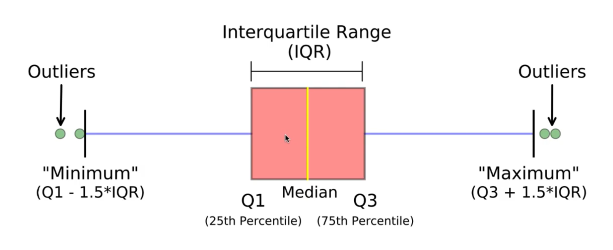

Generate boxplots for all years from the ```complete_hrst``` GeoDataFrame using [**DataFrame.boxplot()**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.boxplot.html).

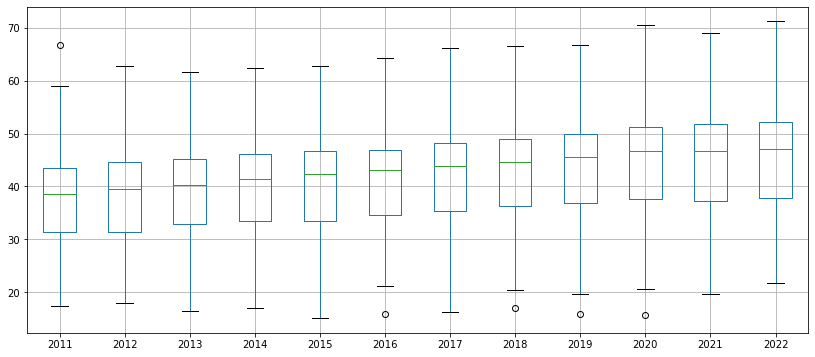

In [33]:
_ = complete_hrst.loc[:, '2011':].boxplot(figsize=(14,6))

The data looks quite symmetric and there are only 5 outliers. Generate now boxplots for all years from the ```nuts2_gdf_hrst``` GeoDataFrame where also regions with null values in some years are included.

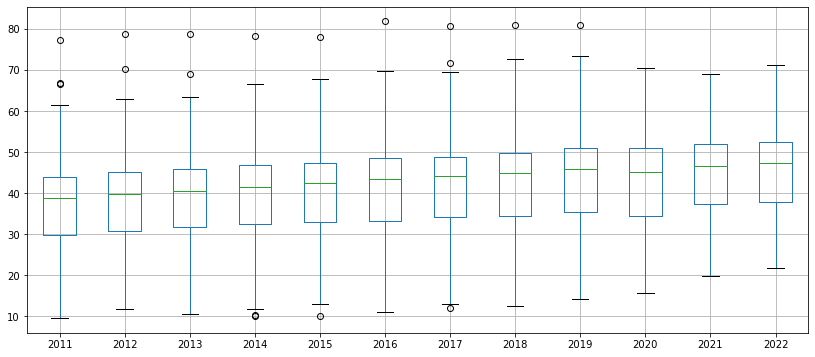

In [34]:
_ = nuts2_gdf_hrst.loc[:, '2011':].boxplot(figsize=(14,6))

You can see that it is a different story now. Quite a lot of outliers especially over the maximum, some of them reaching 80%. Some minimum values, either outliers or standard minima, are as low as 10%.

Let's take a look at which regions are the top and bottom 5 in HRST over the years 2011-2022.

### Bottom 5

In [38]:
# top/bottom 5 selection
def tb5_selection(asc):
    years = ['2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022']
    tb5_df_list = []

    for year in years:
        temp_gdf_hrst = nuts2_gdf_hrst.dropna(subset=year)[:]
        temp_gdf_hrst.sort_values(by=year, ascending=asc, inplace=True, ignore_index=True)

        tb5_year = temp_gdf_hrst.loc[0:4, ('NUTS_ID', 'NAME_LATN', year)]
        tb5_year.columns = ['NUTS_ID', 'NAME_LATN', 'PC_ACT']
        tb5_year['YEAR'] = year
        tb5_df_list.append(tb5_year)

    tb5_df = pandas.concat(tb5_df_list)
    tb5_df['id'] = list(range(1,61))
    return(tb5_df)

In [41]:
top5_df = tb5_selection(False)
top5_df

NUTS_ID                           NAME_LATN  PC_ACT  YEAR  id
0    UKI3                 Inner London — West    77.4  2011   1
1    BE31                Prov. Brabant Wallon    66.8  2011   2
2    UKI4                 Inner London — East    66.6  2011   3
3    UKI7  Outer London — West and North West    61.5  2011   4
4    UKI6                Outer London — South    59.5  2011   5
0    UKI3                 Inner London — West    78.7  2012   6
1    UKI4                 Inner London — East    70.3  2012   7
2    BE31                Prov. Brabant Wallon    62.8  2012   8
3    UKI7  Outer London — West and North West    61.6  2012   9
4    FI1B                    Helsinki-Uusimaa    59.8  2012  10
0    UKI3                 Inner London — West    78.7  2013  11
1    UKI4                 Inner London — East    68.9  2013  12
2    UKI6                Outer London — South    63.5  2013  13
3    PL91                Warszawski stołeczny    62.3  2013  14
4    BE31                Prov. Brabant Wallon    61.7  2013  15
0    UKI3                 Inner London — West    78.3  2014  16
1    UKI4                 Inner London — East    66.6  2014  17
2    PL91                Warszawski stołeczny    64.7  2014  18
3    LU00                          Luxembourg    62.4  2014  19
4    UKI7  Outer London — West and North West    62.0  2014  20
0    UKI3                 Inner London — West    77.9  2015  21
1    UKI4                 Inner London — East    67.7  2015  22
2    PL91                Warszawski stołeczny    65.9  2015  23
3    UKI6                Outer London — South    64.2  2015  24
4    BE31                Prov. Brabant Wallon    62.8  2015  25
0    UKI3                 Inner London — West    81.8  2016  26
1    UKI4                 Inner London — East    69.7  2016  27
2    PL91                Warszawski stołeczny    66.8  2016  28
3    UKI6                Outer London — South    65.0  2016  29
4    UKI7  Outer London — West and North West    64.7  2016  30
0    UKI3                 Inner London — West    80.8  2017  31
1    UKI4                 Inner London — East    71.6  2017  32
2    PL91                Warszawski stołeczny    69.4  2017  33
3    UKI6                Outer London — South    66.3  2017  34
4    BE31                Prov. Brabant Wallon    66.2  2017  35
0    UKI3                 Inner London — West    81.0  2018  36
1    UKI4                 Inner London — East    72.6  2018  37
2    PL91                Warszawski stołeczny    70.7  2018  38
3    BE31                Prov. Brabant Wallon    66.6  2018  39
4    UKI6                Outer London — South    66.4  2018  40
0    UKI3                 Inner London — West    81.0  2019  41
1    UKI4                 Inner London — East    73.3  2019  42
2    UKI7  Outer London — West and North West    69.9  2019  43
3    PL91                Warszawski stołeczny    68.6  2019  44
4    UKI6                Outer London — South    67.6  2019  45
0    BE31                Prov. Brabant Wallon    70.5  2020  46
1    PL91                Warszawski stołeczny    69.1  2020  47
2    SE11                           Stockholm    67.7  2020  48
3    FR10                       Ile-de-France    66.5  2020  49
4    FI1B                    Helsinki-Uusimaa    65.9  2020  50
0    BE31                Prov. Brabant Wallon    69.0  2021  51
1    PL91                Warszawski stołeczny    68.7  2021  52
2    SE11                           Stockholm    68.0  2021  53
3    CZ01                               Praha    67.8  2021  54
4    HU11                            Budapest    67.4  2021  55
0    BE31                Prov. Brabant Wallon    71.2  2022  56
1    PL91                Warszawski stołeczny    68.8  2022  57
2    SE11                           Stockholm    68.6  2022  58
3    LT01                   Sostinės regionas    68.2  2022  59
4    HU11                            Budapest    68.1  2022  60

In [265]:
years = ['2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022']
bottom5_df_list = []

for year in years:
    temp_gdf_hrst = nuts2_gdf_hrst.dropna(subset=year)[:]
    temp_gdf_hrst.sort_values(by=year, inplace=True, ignore_index=True)

    bottom5_year = temp_gdf_hrst.loc[0:4, ('NUTS_ID', 'NAME_LATN', year)]
    bottom5_year.columns = ['NUTS_ID', 'NAME_LATN', 'PC_ACT']
    bottom5_year['YEAR'] = year
    bottom5_df_list.append(bottom5_year)

bottom5_df = pandas.concat(bottom5_df_list)
bottom5_df['id'] = list(range(1,61))
bottom5_df

NUTS_ID                                        NAME_LATN  PC_ACT  YEAR  id
0    TRA2                       Ağrı, Kars, Iğdır, Ardahan     9.6  2011   1
1    TRB2                        Van, Muş, Bitlis, Hakkari    12.2  2011   2
2    TRC1                       Gaziantep, Adıyaman, Kilis    13.0  2011   3
3    TR82                        Kastamonu, Çankırı, Sinop    13.9  2011   4
4    TR33            Manisa, Afyonkarahisar, Kütahya, Uşak    14.1  2011   5
0    TRC2                            Şanlıurfa, Diyarbakır    11.7  2012   6
1    TRA2                       Ağrı, Kars, Iğdır, Ardahan    11.7  2012   7
2    TR33            Manisa, Afyonkarahisar, Kütahya, Uşak    12.2  2012   8
3    TRB2                        Van, Muş, Bitlis, Hakkari    12.3  2012   9
4    TR90  Trabzon, Ordu, Giresun, Rize, Artvin, Gümüşhane    13.9  2012  10
0    TRA2                       Ağrı, Kars, Iğdır, Ardahan    10.5  2013  11
1    TRB2                        Van, Muş, Bitlis, Hakkari    11.3  2013  12
2    TR33            Manisa, Afyonkarahisar, Kütahya, Uşak    12.3  2013  13
3    TRC2                            Şanlıurfa, Diyarbakır    13.1  2013  14
4    TRB1                 Malatya, Elazığ, Bingöl, Tunceli    14.5  2013  15
0    TRB2                        Van, Muş, Bitlis, Hakkari    10.2  2014  16
1    TRA2                       Ağrı, Kars, Iğdır, Ardahan    10.4  2014  17
2    TRC2                            Şanlıurfa, Diyarbakır    11.9  2014  18
3    TRC3                    Mardin, Batman, Şırnak, Siirt    13.3  2014  19
4    TRA1                       Erzurum, Erzincan, Bayburt    13.8  2014  20
0    TRB2                        Van, Muş, Bitlis, Hakkari    10.1  2015  21
1    TRA2                       Ağrı, Kars, Iğdır, Ardahan    13.1  2015  22
2    TRC2                            Şanlıurfa, Diyarbakır    13.1  2015  23
3    TRA1                       Erzurum, Erzincan, Bayburt    14.6  2015  24
4    RO21                                         Nord-Est    15.1  2015  25
0    TRB2                        Van, Muş, Bitlis, Hakkari    11.0  2016  26
1    TRA2                       Ağrı, Kars, Iğdır, Ardahan    12.2  2016  27
2    TRC2                            Şanlıurfa, Diyarbakır    15.1  2016  28
3    RO21                                         Nord-Est    15.8  2016  29
4    TR82                        Kastamonu, Çankırı, Sinop    16.3  2016  30
0    TRB2                        Van, Muş, Bitlis, Hakkari    12.0  2017  31
1    TRA2                       Ağrı, Kars, Iğdır, Ardahan    12.9  2017  32
2    RO21                                         Nord-Est    16.3  2017  33
3    TRC2                            Şanlıurfa, Diyarbakır    17.2  2017  34
4    TR82                        Kastamonu, Çankırı, Sinop    18.4  2017  35
0    TRA2                       Ağrı, Kars, Iğdır, Ardahan    12.5  2018  36
1    TRB2                        Van, Muş, Bitlis, Hakkari    14.8  2018  37
2    TRC2                            Şanlıurfa, Diyarbakır    16.7  2018  38
3    RO21                                         Nord-Est    16.9  2018  39
4    TR63                   Hatay, Kahramanmaraş, Osmaniye    19.6  2018  40
0    TRA2                       Ağrı, Kars, Iğdır, Ardahan    14.1  2019  41
1    RO21                                         Nord-Est    15.9  2019  42
2    TRC2                            Şanlıurfa, Diyarbakır    17.6  2019  43
3    TRB2                        Van, Muş, Bitlis, Hakkari    18.5  2019  44
4    RO31                                     Sud-Muntenia    19.6  2019  45
0    RO21                                         Nord-Est    15.6  2020  46
1    TRC2                            Şanlıurfa, Diyarbakır    19.1  2020  47
2    TRA2                       Ağrı, Kars, Iğdır, Ardahan    19.4  2020  48
3    TRB2                        Van, Muş, Bitlis, Hakkari    19.8  2020  49
4    RO31                                     Sud-Muntenia    20.5  2020  50
0    RO21                                         Nord-Est    19.7  2021  5

In [40]:
print(len(bottom5_df))
bottom5_df.nunique(axis=0)

60


NUTS_ID      17
NAME_LATN    17
PC_ACT       48
YEAR         12
id           60
dtype: int64

In [267]:
unique_nuts_names = bottom5_df['NAME_LATN'].unique().tolist()
unique_nuts = bottom5_df['NUTS_ID'].unique().tolist()

In [268]:
d = {'id': unique_nuts, 'names': unique_nuts_names}
names_id_df = pandas.DataFrame(data=d)
names_id_df.sort_values('id', inplace=True)
unique_nuts_names = names_id_df['names'].to_list()

In [269]:
unique_nuts.sort()

In [270]:
el_colors = ['#0047ab']
ro_colors = ['#f5dd84', '#f2c944', '#ebb141', '#e18f3d']
rs_colors = ['#d0f0c0']
tr_colors = ['#ffc8c8', '#ffb4b4', '#ffa0a0', '#ff8c8c', '#ff7878', '#ff6464', '#ff5050', '#ff3c3c', '#ff2828', '#ff1414', '#ff0000']
nuts_colors = el_colors+ro_colors+rs_colors+tr_colors

my_dict = dict(zip(unique_nuts, nuts_colors))

print(my_dict)

{'EL62': '#0047ab', 'RO21': '#f5dd84', 'RO22': '#f2c944', 'RO31': '#ebb141', 'RO42': '#e18f3d', 'RS21': '#d0f0c0', 'TR33': '#ffc8c8', 'TR63': '#ffb4b4', 'TR82': '#ffa0a0', 'TR90': '#ff8c8c', 'TRA1': '#ff7878', 'TRA2': '#ff6464', 'TRB1': '#ff5050', 'TRB2': '#ff3c3c', 'TRC1': '#ff2828', 'TRC2': '#ff1414', 'TRC3': '#ff0000'}


In [271]:
import matplotlib.pyplot as plt

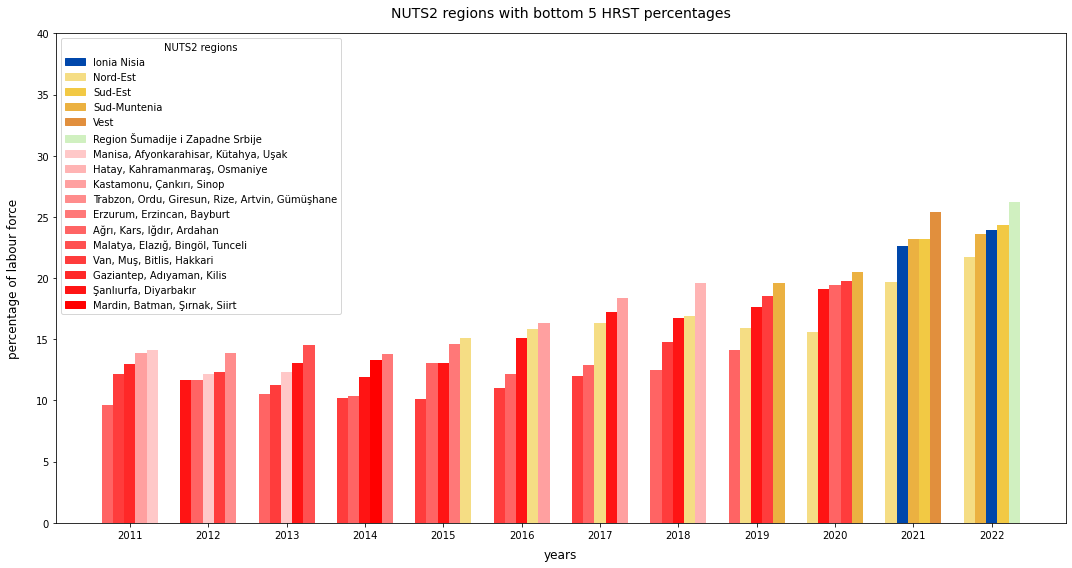

In [272]:
# define an empty list hrst_percentages
hrst_percentages = []

# get the HRST percentages for each year and append them into the  list
for year in years:
    hodnoty = bottom5_df.loc[bottom5_df['YEAR'] == year, 'PC_ACT'].tolist()[:5]
    hrst_percentages.append(hodnoty)

# create a figure which will contain the bar plot
plt.figure(figsize=(15, 8))

# width of each individual bar
bar_width = 0.5

# positions to determine the xticks
positions = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33]
positions_list = []

m = 1

# create a barplot for each year
for i, rok in enumerate(years):
    k = 0
    for j in range(5):
        if j == 2:
            positions_list.append(positions[i] + i * bar_width + k)
        plt.bar(positions[i] + i * bar_width + k, hrst_percentages[i][j], bar_width, 
                color=my_dict[bottom5_df.loc[bottom5_df['id']==m, 'NUTS_ID'][j]])
        k += bar_width
        m += 1
        

legend_labels = [plt.Rectangle((0, 0), 1, 1, color=color) for color in nuts_colors]
plt.legend(legend_labels, unique_nuts_names, title='NUTS2 regions', loc='upper left')

plt.ylim(top=40)
plt.xlabel('years', fontdict={'fontsize':12}, labelpad=8.0)
plt.ylabel('percentage of labour force', fontdict={'fontsize':12}, labelpad=16.0)
plt.title('NUTS2 regions with bottom 5 HRST percentages', fontdict={'fontsize':14}, pad=16.0)
plt.xticks(ticks=positions_list, labels=years)

plt.tight_layout()
plt.show()

In [273]:
bottom5_gdf_list = []
for region in unique_nuts:
    bottom5_gdf_list.append(nuts2_gdf_hrst[nuts2_gdf_hrst['NUTS_ID']==region])

bottom5_gdf = pandas.concat(bottom5_gdf_list)
bottom5_gdf.explore(tiles='CartoDB.Voyager', tooltip=['NAME_LATN'], tooltip_kwds={'aliases':['region name']},
                 attr='© EuroGeographics for the administrative boundaries | (C) OpenStreetMap contributors (C) CARTO')

### Top 5

In [250]:
years = ['2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022']
top5_df_list = []

for year in years:
    temp_gdf_hrst = nuts2_gdf_hrst.dropna(subset=year)[:]
    temp_gdf_hrst.sort_values(by=year, ascending=False, inplace=True, ignore_index=True)

    top5_year = temp_gdf_hrst.loc[0:4, ('NUTS_ID', 'NAME_LATN', year)]
    top5_year.columns = ['NUTS_ID', 'NAME_LATN', 'PC_ACT']
    top5_year['YEAR'] = year
    top5_df_list.append(top5_year)

top5_df = pandas.concat(top5_df_list)
top5_df['id'] = list(range(1,61))
top5_df

NUTS_ID                           NAME_LATN  PC_ACT  YEAR  id
0    UKI3                 Inner London — West    77.4  2011   1
1    BE31                Prov. Brabant Wallon    66.8  2011   2
2    UKI4                 Inner London — East    66.6  2011   3
3    UKI7  Outer London — West and North West    61.5  2011   4
4    UKI6                Outer London — South    59.5  2011   5
0    UKI3                 Inner London — West    78.7  2012   6
1    UKI4                 Inner London — East    70.3  2012   7
2    BE31                Prov. Brabant Wallon    62.8  2012   8
3    UKI7  Outer London — West and North West    61.6  2012   9
4    FI1B                    Helsinki-Uusimaa    59.8  2012  10
0    UKI3                 Inner London — West    78.7  2013  11
1    UKI4                 Inner London — East    68.9  2013  12
2    UKI6                Outer London — South    63.5  2013  13
3    PL91                Warszawski stołeczny    62.3  2013  14
4    BE31                Prov. Brabant Wallon    61.7  2013  15
0    UKI3                 Inner London — West    78.3  2014  16
1    UKI4                 Inner London — East    66.6  2014  17
2    PL91                Warszawski stołeczny    64.7  2014  18
3    LU00                          Luxembourg    62.4  2014  19
4    UKI7  Outer London — West and North West    62.0  2014  20
0    UKI3                 Inner London — West    77.9  2015  21
1    UKI4                 Inner London — East    67.7  2015  22
2    PL91                Warszawski stołeczny    65.9  2015  23
3    UKI6                Outer London — South    64.2  2015  24
4    BE31                Prov. Brabant Wallon    62.8  2015  25
0    UKI3                 Inner London — West    81.8  2016  26
1    UKI4                 Inner London — East    69.7  2016  27
2    PL91                Warszawski stołeczny    66.8  2016  28
3    UKI6                Outer London — South    65.0  2016  29
4    UKI7  Outer London — West and North West    64.7  2016  30
0    UKI3                 Inner London — West    80.8  2017  31
1    UKI4                 Inner London — East    71.6  2017  32
2    PL91                Warszawski stołeczny    69.4  2017  33
3    UKI6                Outer London — South    66.3  2017  34
4    BE31                Prov. Brabant Wallon    66.2  2017  35
0    UKI3                 Inner London — West    81.0  2018  36
1    UKI4                 Inner London — East    72.6  2018  37
2    PL91                Warszawski stołeczny    70.7  2018  38
3    BE31                Prov. Brabant Wallon    66.6  2018  39
4    UKI6                Outer London — South    66.4  2018  40
0    UKI3                 Inner London — West    81.0  2019  41
1    UKI4                 Inner London — East    73.3  2019  42
2    UKI7  Outer London — West and North West    69.9  2019  43
3    PL91                Warszawski stołeczny    68.6  2019  44
4    UKI6                Outer London — South    67.6  2019  45
0    BE31                Prov. Brabant Wallon    70.5  2020  46
1    PL91                Warszawski stołeczny    69.1  2020  47
2    SE11                           Stockholm    67.7  2020  48
3    FR10                       Ile-de-France    66.5  2020  49
4    FI1B                    Helsinki-Uusimaa    65.9  2020  50
0    BE31                Prov. Brabant Wallon    69.0  2021  51
1    PL91                Warszawski stołeczny    68.7  2021  52
2    SE11                           Stockholm    68.0  2021  53
3    CZ01                               Praha    67.8  2021  54
4    HU11                            Budapest    67.4  2021  55
0    BE31                Prov. Brabant Wallon    71.2  2022  56
1    PL91                Warszawski stołeczny    68.8  2022  57
2    SE11                           Stockholm    68.6  2022  58
3    LT01                   Sostinės regionas    68.2  2022  59
4    HU11                            Budapest    68.1  2022  60

In [251]:
print(len(top5_df))
top5_df.nunique(axis=0)

60


NUTS_ID      13
NAME_LATN    13
PC_ACT       50
YEAR         12
id           60
dtype: int64

In [252]:
unique_nuts_names = top5_df['NAME_LATN'].unique().tolist()
unique_nuts = top5_df['NUTS_ID'].unique().tolist()

In [253]:
d = {'id': unique_nuts, 'names': unique_nuts_names}
names_id_df = pandas.DataFrame(data=d)
names_id_df.sort_values('id', inplace=True)
unique_nuts_names = names_id_df['names'].to_list()

In [254]:
unique_nuts.sort()

In [256]:
be_colors = ['#bab0ac'] # grey
cz_colors = ['#f28e2b'] # orange
fi_colors = ['#76b7b2'] # light blue
fr_colors = ['#b07aa1'] # purple
hu_colors = ['#9c755f'] # brown
lt_colors = ['#59a14f'] # green
lu_colors = ['#ff9da7'] # pink
pl_colors = ['#e15759'] # red
se_colors = ['#edc948'] # yellow
uk_colors = ['#349eeb', '#4e79a7', '#5bb2f0', '#3158e8'] # blues
nuts_colors = be_colors+cz_colors+fi_colors+fr_colors+hu_colors+lt_colors+lu_colors+pl_colors+se_colors+uk_colors

my_dict = dict(zip(unique_nuts, nuts_colors))

print(my_dict)

{'BE31': '#bab0ac', 'CZ01': '#f28e2b', 'FI1B': '#76b7b2', 'FR10': '#b07aa1', 'HU11': '#9c755f', 'LT01': '#59a14f', 'LU00': '#ff9da7', 'PL91': '#e15759', 'SE11': '#edc948', 'UKI3': '#349eeb', 'UKI4': '#4e79a7', 'UKI6': '#5bb2f0', 'UKI7': '#3158e8'}


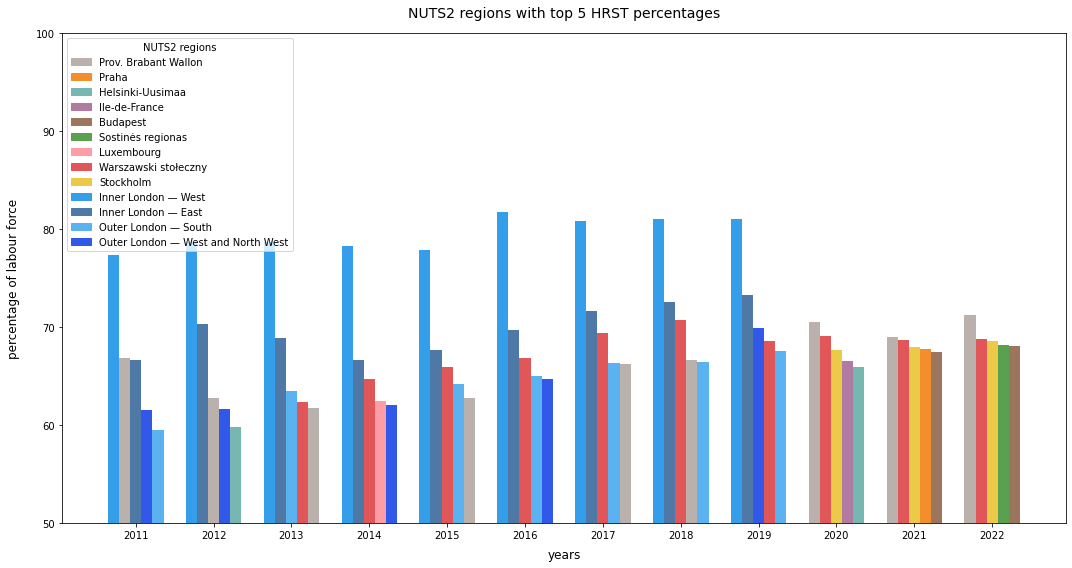

In [260]:
# define an empty list hrst_percentages
hrst_percentages = []

# get the HRST percentages for each year and append them into the  list
for year in years:
    hodnoty = top5_df.loc[top5_df['YEAR'] == year, 'PC_ACT'].tolist()[:5]
    hrst_percentages.append(hodnoty)

# create a figure which will contain the bar plot
plt.figure(figsize=(15, 8))

# width of each individual bar
bar_width = 0.5

# positions to determine the xticks
positions = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33]
positions_list = []

m = 1

# create a barplot for each year
for i, rok in enumerate(years):
    k = 0
    for j in range(5):
        if j == 2:
            positions_list.append(positions[i] + i * bar_width + k)
        plt.bar(positions[i] + i * bar_width + k, hrst_percentages[i][j], bar_width, 
                color=my_dict[top5_df.loc[top5_df['id']==m, 'NUTS_ID'][j]])
        k += bar_width
        m += 1
        
legend_labels = [plt.Rectangle((0, 0), 1, 1, color=color) for color in nuts_colors]
plt.legend(legend_labels, unique_nuts_names, title='NUTS2 regions', loc='upper left')

plt.ylim(bottom=50, top=100)
plt.xlabel('years', fontdict={'fontsize':12}, labelpad=8.0)
plt.ylabel('percentage of labour force', fontdict={'fontsize':12}, labelpad=16.0)
plt.title('NUTS2 regions with top 5 HRST percentages', fontdict={'fontsize':14}, pad=16.0)
plt.xticks(ticks=positions_list, labels=years)

plt.tight_layout()
plt.show()

In [264]:
top5_gdf_list = []
for region in unique_nuts:
    top5_gdf_list.append(nuts2_gdf_hrst[nuts2_gdf_hrst['NUTS_ID']==region])

top5_gdf = pandas.concat(top5_gdf_list)
top5_gdf.explore(tiles='CartoDB.Voyager', tooltip=['NAME_LATN'], tooltip_kwds={'aliases':['region name']},
                 attr='© EuroGeographics for the administrative boundaries | (C) OpenStreetMap contributors (C) CARTO')

### Maps

After all those tables, plots, boxplots and histograms it's time to visualize HRST dataset on a map. Let's create a simple static map for all NUTS2 regions by the **GeoDataFrame.plot()** function. It has a lot of parameters that enable configuring the map. 

The color scale is specified in the ```cmap``` parameter. You can choose various color scales from [matplotlib colormaps](https://matplotlib.org/stable/users/explain/colors/colormaps.html). If you want to create a choropleth map with graduated colors, which is this case, determine how the values will be divided into intervals in the ```scheme``` parameter. Style polygons with missing values by ```missing_kwds``` dictionary.

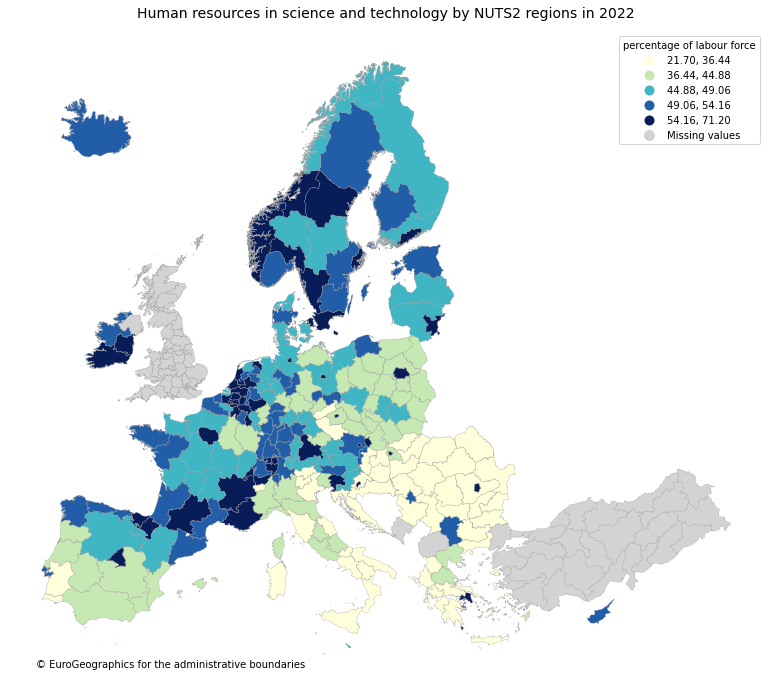

In [43]:
ax = nuts2_gdf_hrst.plot(column='2022', cmap='YlGnBu', scheme='Quantiles', k=5, 
                         figsize=(16,12), edgecolor='#9e9d9d', linewidth=0.3,
                         legend=True, legend_kwds={'title':'percentage of labour force'},
                         missing_kwds={"color": "lightgrey", "label": "Missing values"},)
ax.set_title('Human resources in science and technology by NUTS2 regions in 2022', fontsize=14, pad=14.0)
ax.text(x=2600000.0, y=1300000.0, s='© EuroGeographics for the administrative boundaries')
ax.set_axis_off()

Now let's focus on a certain part of Europe, for example Central Europe. Central Europe can be defined in a lot of different ways, but for this notebook it consists of these countries: Germany, Switzerland, Austria, Hungary, Slovakia, Czech Republic and Poland. 

Create a subset of the ```nuts2_gdf_hrst``` GeoDataFrame by selecting only Central European NUTS2 regions and saving them in a new GeoDataFrame named ```ce_gdf_hrst```. There is a step-by-step guide on how to do it in the code cell comments.

In [45]:
# define an empty list
ce_df_list = []
# define a list with country codes of Central European countries
ce_codes = ['SK', 'CZ', 'HU', 'PL', 'AT', 'DE', 'CH']
# loop through the list above
for country in ce_codes:
    # append (add) GeoDataFrame of NUTS2 regions of the current country to the originally empty list
    ce_df_list.append(nuts2_gdf_hrst[nuts2_gdf_hrst['CNTR_CODE']==country])

# pandas.concat method merges/appends (Geo)DataFrames together into one (Geo)DataFrame
ce_gdf_hrst = pandas.concat(ce_df_list)

You are going to create an interactive leaflet map of the Central Europeen NUTS2 regions. You can use [**folium**](https://python-visualization.github.io/folium/latest/index.html) package directly by importing it and working with it or you can use this package indirectly via [**GeoDataFrame.explore()**](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.explore.html) function. This function uses **folium** to generate a leaflet map. It has a lot of parameters that enable customizing the map.

Parameter ```tiles``` specifies the basemap. You can choose any basemap from [xyzservices](https://xyzservices.readthedocs.io/en/stable/gallery.html). Parameter ```tooltip``` determines which columns will be shown when hovering over the layer. The other parameters are explained in the function documentation. Parameters ```column```, ```cmap```, ```legend```, ```scheme``` and ```k``` will be the same as for the static map few cells above.

In [46]:
ce_gdf_hrst.explore(column='2022', cmap='YlGnBu', legend=True, scheme='Quantiles', k=5, tiles='CartoDB.Voyager',
                    tooltip=['NAME_LATN', '2022'], popup=['NAME_LATN', 'NUTS_ID', '2020', '2021', '2022'],
                    style_kwds={'stroke':True, 'color':'#9e9d9d', 'width':1, 'fillOpacity':0.8},
                    highlight_kwds={'fillColor':'yellow', 'fillOpacity': 0.4},
                    legend_kwds={'caption':'percentage of labour force employed/educated in science and technology in 2022', 'scale':True},
                    tooltip_kwds={'aliases':['region name', '2022 HRST %']}, 
                    popup_kwds={'aliases':['region name', 'region id', '2020 HRST %', '2021 HRST %', '2022 HRST %']},
                    attr='© EuroGeographics for the administrative boundaries | (C) OpenStreetMap contributors (C) CARTO')

Universities and institutes that educate and employ people in science and technology are located mainly in national capitals and bigger cities. Therefore their percentage of HRST might be higher than other regions in their respective countries. Let's focus on the biggest cities in the Central Europe.

Create a DataFrame named ```capitals``` which will contain data for the biggest cities of Central European countries. For all of them their biggest city is their capital except for Switzerland, where Bern is the capital but Zürich is the biggest city. You can use the same approach as when selecting the NUTS2 regions of Central European countries.

In [38]:
capital_df_list = []
capitals_names = ['Warszawski stołeczny', 'Budapest', 'Praha', 'Berlin', 'Zürich', 'Bratislavský kraj', 'Wien']
for capital in capitals_names:
    capital_df_list.append(nuts2_gdf_hrst[nuts2_gdf_hrst['NUTS_NAME']==capital])

capitals = pandas.concat(capital_df_list)

Keep only the important columns for creating a line plot, which in this case are region's names and the HRST data for years 2014-2022. Warsaw and Budapest miss the data for years 2011 and 2012, that's the reason why those years will be excluded from the plot.

[**DataFrame.T**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.T.html) function transposes the DataFrame, so the columns become index and vice-versa. Then you need to specify that the columns should be the NUTS2 name using [**DataFrame.columns**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.columns.html). In the end [**drop()**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) the extra row with NUTS2 names and print the ```capitals```.

In [39]:
capitals = capitals.loc[:, ('NUTS_NAME','2014','2015','2016','2017','2018','2019','2020','2021','2022')]
capitals = capitals.T
capitals.columns = capitals.loc['NUTS_NAME', :]
capitals.drop(index='NUTS_NAME', inplace=True)
capitals

NUTS_NAME Warszawski stołeczny Budapest Praha Berlin Zürich Bratislavský kraj  \
2014                      64.7     56.6  57.3   53.8   56.9              56.4   
2015                      65.9     56.7  55.8   54.0   58.2              54.2   
2016                      66.8     55.4  58.5   57.3   60.2              54.0   
2017                      69.4     55.8  60.2   58.5   61.5              58.1   
2018                      70.7     58.9  60.4   60.4   62.8              57.4   
2019                      68.6     60.3  61.4   61.6   64.9              60.4   
2020                      69.1     62.6  63.3   61.5   65.5              60.5   
2021                      68.7     67.4  67.8   65.2   65.3              63.5   
2022                      68.8     68.1  67.8   66.5   65.4              62.7   

NUTS_NAME  Wien  
2014       56.6  
2015       56.1  
2016       55.9  
2017       56.9  
2018       55.5  
2019       56.6  
2020       57.2  
2021       57.9  
2022       60.1

Create the line plot and check how the HRST percentages in the Central European capitals and the biggest Swiss city progress throughout the years 2014-2022. 

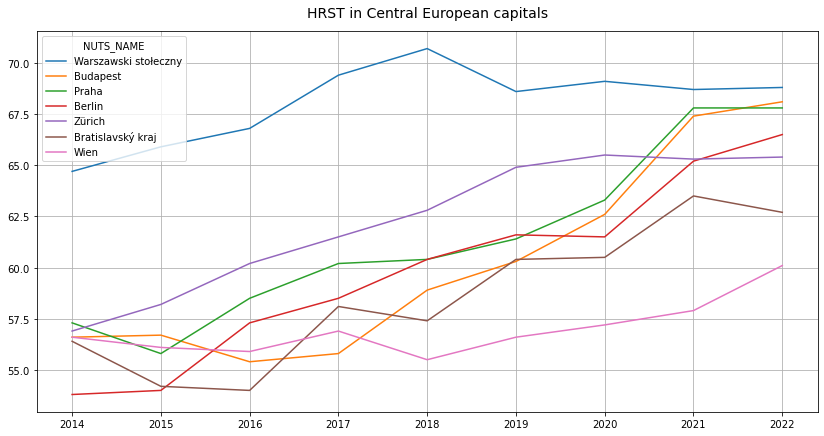

In [40]:
ax = capitals.plot(figsize=(14,7), grid=True)
_ = ax.set_title('HRST in Central European capitals', fontsize=14, pad=14.0)